*** Step 6 -- Model Training

In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import os

In [2]:
df = pd.read_csv(r"C:\Users\HomePC\Crypto-BuySell-Classifier-Model\notebooks\data\processed\BTCUSDT_1dmodified.csv")

In [3]:
#Define features and target variable
feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'quote_asset_volume', 'num_trades',
    'taker_base_volume', 'taker_quote_volume',
    'return_1d', 'return_7d', 'volatility_7d',
    'rsi', 'macd', 'sma_20', 'sma_50', 'sma_200',
    'bb_high', 'bb_low', 'bb_pct',
    'stoch_rsi', 'stoch_rsi_d', 'stoch_rsi_k',
    'future_return'
]

X = df[feature_cols]
y = df["label"]
#Fix missing values
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
#Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [22]:
#Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

***Logistic Regression

In [23]:
#Logistic Regression Model

model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced',max_iter=1000)
model_lr.fit(X_train_scaled, y_train)


c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


*** Random forest classifier

In [26]:
# Random Forest Classifier
model_rf = RandomForestClassifier(class_weight="balanced")
model_rf.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


*** Catboost model

In [45]:
# CatBoost model
model_cat = CatBoostClassifier(
    depth=6,
    learning_rate=0.03,
    loss_function="MultiClass",
    verbose=0
)

model_cat.fit(X_train, y_train)


*** LightGBM Model

In [46]:
#LightGBM model
model_lgb = LGBMClassifier(class_weight="balanced")
# --- Train ---
model_lgb.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006641
[LightGBM] [Debug] init for col-wise cost 0.001158 seconds, init for row-wise cost 0.002414 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


*** XGBoost model

In [47]:
#XGBoost model
model_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss"
)
model_xgb.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


*** Step 7-Evalution of the models

In [9]:
#Evaluation of logistic regression
y_pred_lr = model_lr.predict(X_val_scaled)
print("\n=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr, digits=4))
print(confusion_matrix(y_val, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.7857    1.0000    0.8800        11
           1     0.9815    0.9464    0.9636        56
           2     1.0000    0.9231    0.9600        13

    accuracy                         0.9500        80
   macro avg     0.9224    0.9565    0.9345        80
weighted avg     0.9576    0.9500    0.9515        80

[[11  0  0]
 [ 3 53  0]
 [ 0  1 12]]


In [37]:
# Catboost Evaluation
y_pred_cat = model_cat.predict(X_val)
print("\n=== CatBoost ===")
print(classification_report(y_val, y_pred_cat, digits=4))
print(confusion_matrix(y_val, y_pred_cat))


=== CatBoost ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        11
           1     0.9825    1.0000    0.9912        56
           2     1.0000    0.9231    0.9600        13

    accuracy                         0.9875        80
   macro avg     0.9942    0.9744    0.9837        80
weighted avg     0.9877    0.9875    0.9873        80

[[11  0  0]
 [ 0 56  0]
 [ 0  1 12]]


In [34]:
# Evaluation of LightGBM
y_pred_lgb = model_lgb.predict(X_val)
print("\n=== LightGBM ===")
print(classification_report(y_val, y_pred_lgb, digits=4))
print(confusion_matrix(y_val, y_pred_lgb))


=== LightGBM ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        11
           1     1.0000    1.0000    1.0000        56
           2     1.0000    1.0000    1.0000        13

    accuracy                         1.0000        80
   macro avg     1.0000    1.0000    1.0000        80
weighted avg     1.0000    1.0000    1.0000        80

[[11  0  0]
 [ 0 56  0]
 [ 0  0 13]]


In [35]:
# Evluation random Forest
y_pred_rf = model_rf.predict(X_val)
print("\n=== Random Forest ===")
print(classification_report(y_val, y_pred_rf, digits=4))
print(confusion_matrix(y_val, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        11
           1     0.7000    1.0000    0.8235        56
           2     0.0000    0.0000    0.0000        13

    accuracy                         0.7000        80
   macro avg     0.2333    0.3333    0.2745        80
weighted avg     0.4900    0.7000    0.5765        80

[[ 0 11  0]
 [ 0 56  0]
 [ 0 13  0]]


c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Lib\site-packages\sklea

In [36]:
#XGBoost Evaluation
y_val_pred = model_xgb.predict(X_val)
print("\n=== XGBoost ===")
print(classification_report(y_val, y_val_pred, digits=4))
print(confusion_matrix(y_val, y_val_pred))



=== XGBoost ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        11
           1     0.9825    1.0000    0.9912        56
           2     1.0000    0.9231    0.9600        13

    accuracy                         0.9875        80
   macro avg     0.9942    0.9744    0.9837        80
weighted avg     0.9877    0.9875    0.9873        80

[[11  0  0]
 [ 0 56  0]
 [ 0  1 12]]


# Backtesting

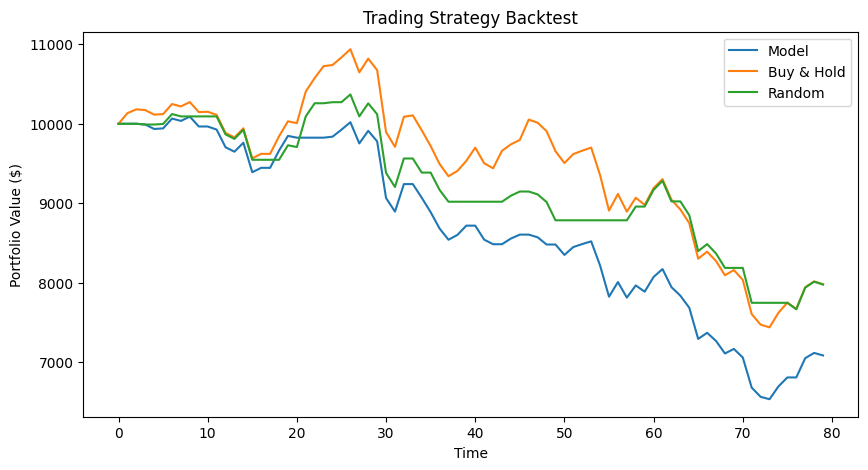

Final portfolio values:
Model: $7081.99
Buy & Hold: $7978.69
Random: $7975.15


In [48]:
# Initial capital
capital = 10000
prices = df["close"].values[-len(y_val):]  # validation period prices
signals = model_cat.predict(X_val) # replace with any model predictions: 0=HOLD, 1=BUY, 2=SELL

# Simulate strategy
def simulate(prices, signals):
    cash, coin = capital, 0
    portfolio = []
    for p, s in zip(prices, signals):
        if s == 1 and cash > 0:    # BUY
            coin, cash = cash / p, 0
        elif s == 2 and coin > 0:  # SELL
            cash, coin = coin * p, 0
        portfolio.append(cash + coin * p)
    return portfolio

model_portfolio = simulate(prices, signals)
buy_hold_portfolio = [capital / prices[0] * p for p in prices]
random_portfolio = simulate(prices, np.random.choice([0,1,2], len(prices)))

# Plot results
plt.figure(figsize=(10,5))
plt.plot(model_portfolio, label="Model")
plt.plot(buy_hold_portfolio, label="Buy & Hold")
plt.plot(random_portfolio, label="Random")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.title("Trading Strategy Backtest")
plt.legend()
plt.show()

# Final results
print("Final portfolio values:")
print(f"Model: ${model_portfolio[-1]:.2f}")
print(f"Buy & Hold: ${buy_hold_portfolio[-1]:.2f}")
print(f"Random: ${random_portfolio[-1]:.2f}")

** Logistic regression is our best model to use

# Step 8-Serialize the Model

In [16]:
# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Export all trained models
joblib.dump(model_lr, "models/logistic_regression.pkl")
joblib.dump(model_rf, "models/random_forest.pkl")
joblib.dump(model_cat, "models/catboost.pkl")
joblib.dump(model_lgb, "models/lightgbm.pkl")
joblib.dump(model_xgb, "models/xgboost.pkl")

# Also save the scaler for preprocessing
joblib.dump(scaler, "models/scaler.pkl")

# Save feature columns for reference
import json
with open("models/feature_columns.json", "w") as f:
    json.dump(feature_cols, f)

print("All models and preprocessing artifacts saved successfully!")

All models and preprocessing artifacts saved successfully!


In [17]:
#Best model: Logistic Regression (save)

joblib.dump(model_lr, "models/best_model.pkl")
print("Best model (logistic_regression) saved as models/best_model.pkl")


Best model (logistic_regression) saved as models/best_model.pkl


# Step 9-Prediction Pipeline

In [49]:
def predict(features):
    model = joblib.load("models/buy_sell_classifier.pkl")
    return model.predict(features)

In [58]:
#Predict function example
model = joblib.load("models/logistic_regression.pkl")

def predict(features):
    return model.predict(features)

In [59]:
features = [[40000, 40500, 39500, 40200, 1234,5555,
              1200, 600, 300,0.01, 0.03, 0.05,
              55,-12, 39700, 39000, 35000,
              41000, 39000, 0.6, 0.7, 0.65, 0.72, 0.02]]
print(predict(features))

[0]
